Итак, я хочу изучать vision transformer'ы и решил поработать с датасетом MNIST, потому что он очень популярный, а значит для него можно найти много готовых туториалов.

In [ ]:
import sklearn.datasets

images, target = sklearn.datasets.load_digits(return_X_y=True, as_frame=True)
print(images.shape)

(1797, 64)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mnist(data, target, dim):
  names = [i for i in range(10)]
  plt.figure(figsize=(15, 8))
  for i in range(7):
      plt.subplot(5, 8, i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(np.array(data.iloc[i]).reshape(dim), cmap=plt.cm.binary)
      plt.xlabel(names[int(target[i])])
  plt.show()

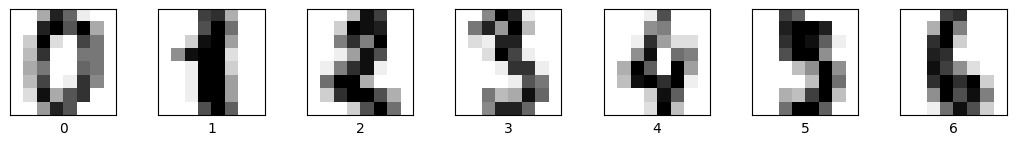

In [ ]:
plot_mnist(images, target, (8, 8))

Я хочу научиться кластеризовать изображения, причём делать это как можно более точно и объясняемо. Так как в общем случае число кластеров в наборе изображений неизвестно, я буду использовать аггломеративную кластеризацию и подбирать пороги расстояний между элементами кластеров.

MNIST хорош тем, что даёт много априорной информации о себе, а именно:
- цифр всего 10;
- есть возможность "оценивать на глаз", насколько похожи или различны те или иные цифры.

Итак, цель моей работы с датасетом MNIST состоит в кластеризации исходных изображений таким образом, чтобы
- выделилось ровно 10 кластеров;
- все межкластерные расстояния были максимальными, а пересечения кластеров, наоборот, минимальными;
- результат кластеризации был интерпертируемым, то есть таким, чтобы его можно было визуализировать и понять, за счёт чего меняются метрики и в каком направлении надо двигаться.
- делать всё вышеперечисленное как можно быстрее, с прицелом на realtime.

Говоря именно про первую лабу, я хочу научиться разделять данные как можно более чётко, чтобы их можно было кластеризовать. А разделять надо по каким-то скрытым признакам (закономерностям), которые ещё надо выявить. Например, с помощью методов снижения размерности пространства.

Также отмечу, что кластеризация для меня является в том числе и способом оценки качества разбиения/представления исходных данных.

In [ ]:
X, y_true = images, target.astype(int)
X = X.astype(np.float32) / 255.0

In [ ]:
import umap
!pip install umap-learn[plot]
import umap.plot
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import time

Потыкаем 3 метода снижения размерности данных. (WARN: кажется, в последних строках t-SNE и PCA перепутаны)

|  | [t-SNE](http://distill.pub/2016/misread-tsne/)    | PCA      | UMAP     |
| :----------------- | :------- | :-------- | :--------- |
| Линейность      | Да       | Нет       | Нет        |
| Детерминированность      | Да (условно)       | Нет       | Нет        |
| Обучаемость      | Нет (условно)       | Да       | Да        |
| Выявляет структуру      | Только глобальную       | Локальную, отчасти глобальную       | Локальную, отчасти глобальную        |
| Как уменьшается размерность   | По вероятности распределения          | По компонентам           | Сначала с помощью функции k ближайших соседей, а затем со всеми расстояниями между данными внутри этого пространства  |
| Как рассчитывается проекция данных   | Энтропийное расстояние | Коэффициенты регрессии в направлении первых компонентов стохастического распределения | Расстояния между двумя точками в меньшей размерности |

In [ ]:
def plot_mnist_scatter(title, X, y, n_components=2, perplexity=40, display_labels=False):
  start = time.process_time()
  pca_embeddings = PCA(n_components=n_components).fit_transform(X)
  pca_time = time.process_time() - start

  start = time.process_time()
  tsne_embeddings = TSNE(n_components=n_components, perplexity=perplexity).fit_transform(X)
  tsne_time = time.process_time() - start

  start = time.process_time()
  umap_embeddings = UMAP(n_components=n_components).fit_transform(X)
  umap_time = time.process_time() - start

  print([pca_time, tsne_time, umap_time])

  plt.title('Compute time')
  plt.bar(np.arange(3), [pca_time, tsne_time, umap_time])
  plt.xlabel('Method')
  plt.ylabel('Time, seconds')
  plt.xticks(np.arange(3), ['PCA', 't-SNE', 'UMAP'])
  plt.show()

  fig, plots = plt.subplots(1, 3, figsize=(15, 7))
  fig.suptitle(title)
  plt.prism()

  for i in range(len(np.unique(y))):
      digit_indices = (y == i)

      dim0 = pca_embeddings[digit_indices, 0]
      dim1 = pca_embeddings[digit_indices, 1]
      plots[0].set_title('PCA')
      plots[0].scatter(dim0, dim1, label=f"Digit {i}" if display_labels else None)
      plots[0].legend()

      dim0 = tsne_embeddings[digit_indices, 0]
      dim1 = tsne_embeddings[digit_indices, 1]
      plots[1].set_title('t-SNE')
      plots[1].scatter(dim0, dim1, label=f"Digit {i}" if display_labels else None)
      plots[1].legend()

      dim0 = umap_embeddings[digit_indices, 0]
      dim1 = umap_embeddings[digit_indices, 1]
      plots[2].set_title('UMAP')
      plots[2].scatter(dim0, dim1, label=f"Digit {i}" if display_labels else None)
      plots[2].legend()

  plt.tight_layout()
  plt.legend()
  plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[0.012190522000082638, 21.715369216, 8.59601244999999]


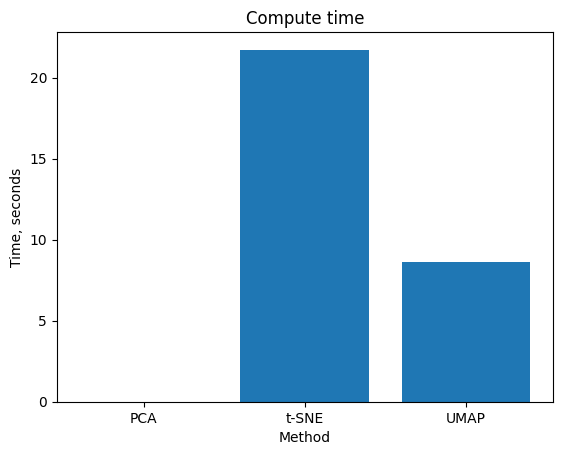

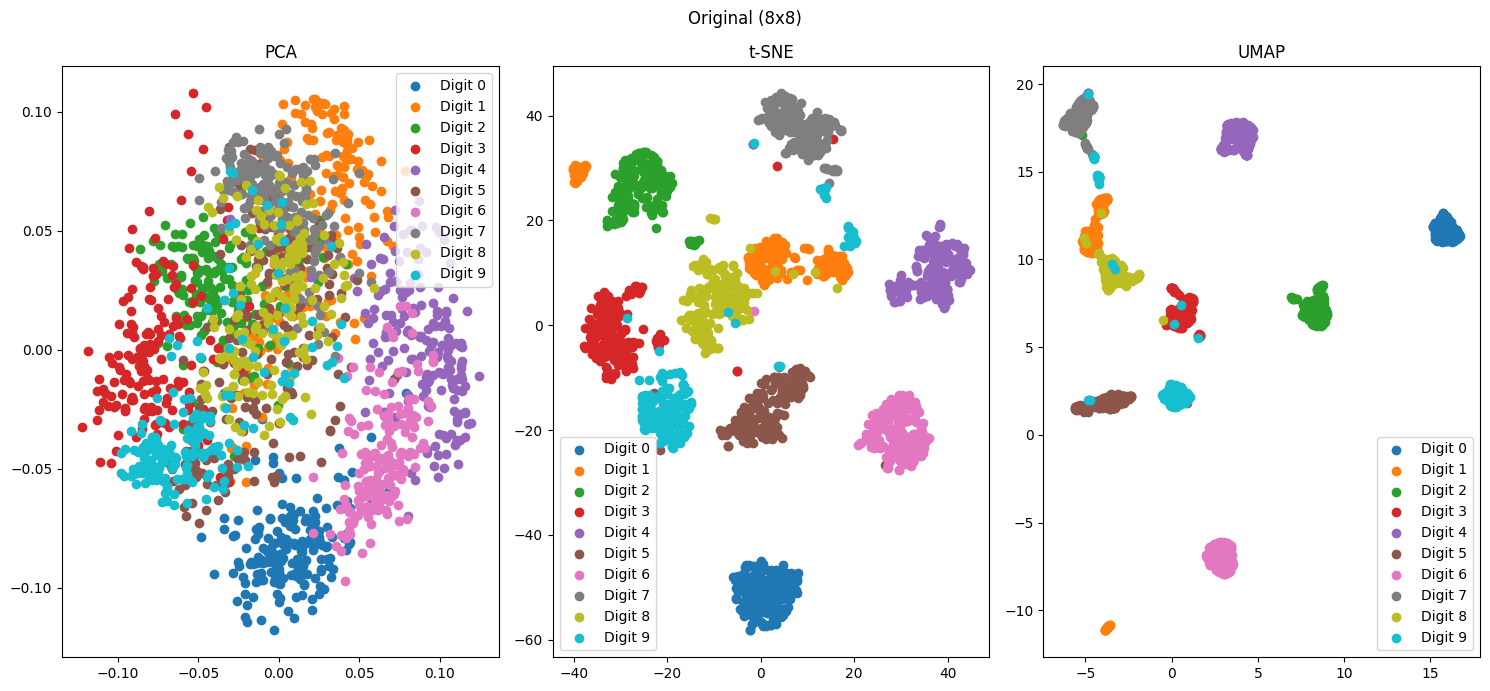

In [ ]:
plot_mnist_scatter('Original (8x8)', X, y_true, display_labels=True)

Видим, что PCA - с отрывом самый быстрый, t-SNE - самый медленный. Поэтому в первую очередь присмотримся подробнее к PCA.

И на будущее выдвину гипотезы о том, что эмбеддинги PCA лучше кластеризовать по косинусному расстоянию, а t-SNE и UMAP - по евклидову.

Сделаем первую попытку кластеризации "в лоб" (для исходных картинок).

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score, davies_bouldin_score, calinski_harabasz_score

clustering = AgglomerativeClustering(n_clusters=10, metric='euclidean', linkage='ward')

start = time.process_time()
y_pred = clustering.fit_predict(X)
diff = time.process_time() - start

start_metrics = {
    'Time': diff,
    'ARI': round(adjusted_rand_score(y_true, y_pred), 3),
}

print(start_metrics)

{'Time': 0.16725778800014268, 'ARI': 0.794}


Полученный ARI будем считать нашей отправной точкой.

Теперь делаем эмбеддинги для PCA, t-SNE и UMAP.

In [ ]:
pca_2d_embeddings = PCA(n_components=2).fit_transform(X)
tsne_2d_embeddings = TSNE(n_components=2, perplexity=40).fit_transform(X)
umap_2d_embeddings = UMAP(n_components=2).fit_transform(X)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Для оценки качества кластеризации я буду использовать ARI.
Он принимает значения от -1 до 1, где
- 1 - идеальная кластеризация;
- 0 - случайное разбиение;
- -1 - ещё хуже.

Под эту метрику и будем подбирать distance threshold, считая количество кластеров неизвестным.

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

def evaluate_clustering(X, y_true, distance_threshold, metric='euclidean', linkage='ward'):
    clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=distance_threshold, metric=metric, linkage=linkage)

    start = time.process_time()
    y_pred = clustering.fit_predict(X)
    diff = time.process_time() - start

    n_clusters = len(np.unique(y_pred))

    return y_pred, n_clusters, {
        'Time': diff,
        'ARI': adjusted_rand_score(y_true, y_pred),
    }

def find_optimal_clustering(X, y_true, metric='euclidean', linkage='ward', iterations=1000):
    optimal_threshold = None
    best_metrics = None
    y_optimal = None
    n_clusters_optimal = None

    dist = pairwise_distances(X, metric=metric)

    for threshold in np.linspace(np.min(dist), np.max(dist), iterations):
        #print(threshold, metric, linkage)
        y_pred, n_clusters, metrics = evaluate_clustering(dist, y_true, threshold, 'precomputed', linkage)

        ari = metrics['ARI']
        if best_metrics is None or ari > best_metrics['ARI']:
            best_metrics = metrics
            y_optimal = y_pred
            optimal_threshold = threshold
            n_clusters_optimal = n_clusters

    return optimal_threshold, best_metrics, y_optimal, n_clusters_optimal

In [ ]:
def print_clustering(threshold, metrics, start_metrics, n_clusters):
  diff = {
      'Time': (metrics['Time']-start_metrics['Time'])/start_metrics['Time']*100,
      'ARI': (metrics['ARI']-start_metrics['ARI'])/start_metrics['ARI']*100,
  }
  print(f'N clusters: {n_clusters}')
  print(f'Threshold: {threshold}')
  print(f'Metrics:')
  print('\tTime: {:.3f} sec. ({:+.0f}%)'.format(metrics['Time'], diff['Time']))
  print('\tARI: {:.3f} ({:+.0f}%)'.format(metrics['ARI'], diff['ARI']))

Для начала просто поиграемся, кластеризовав эмбеддинги по евклидову и косинусному расстоянию.

In [ ]:
threshold_pca, metrics_pca, y_pca, n_clusters = find_optimal_clustering(pca_2d_embeddings, y_true, linkage='average')

print_clustering(threshold_pca, metrics_pca, start_metrics, n_clusters)

N clusters: 13
Threshold: 0.04335311283399393
Metrics:
	Time: 0.096 sec. (-43%)
	ARI: 0.378 (-52%)


In [ ]:
threshold_pca, metrics_pca, y_pca, n_clusters = find_optimal_clustering(pca_2d_embeddings, y_true, metric='cosine', linkage='average')

print_clustering(threshold_pca, metrics_pca, start_metrics, n_clusters)

N clusters: 11
Threshold: 0.09009009009009009
Metrics:
	Time: 0.086 sec. (-49%)
	ARI: 0.351 (-56%)


ARI упал в 2 раза - неприятно. Что ж, будем исправлять ситуацию.

Из настроек кластеризации помимо числа кластеров (нельзя задавать) и distance threshold есть ещё различные способы считать расстояние между точками в нашем новом пространстве признаков, а также критерии связи (определяет, какое расстояние использовать между наборами; алгоритм объединит кластеры, которые минимизируют этот критерий).

Критерии связи:
- **ward** сводит к минимуму дисперсию объединенных кластеров.
- **average** использует среднее расстояние каждого элемента двух кластеров.
- **complete** or **maximum linkage** использует максимальные расстояния между всеми элементами двух кластеров.
- **single** использует минимум расстояний между всеми элементами двух кластеров.

Расстояния:
- Евклидово (l1-norm).
- l2-norm (более чувствительно к выбросам).
- Манхеттенское расстояние (менее чувствительно к выбросам).
- Косинусное расстояние.

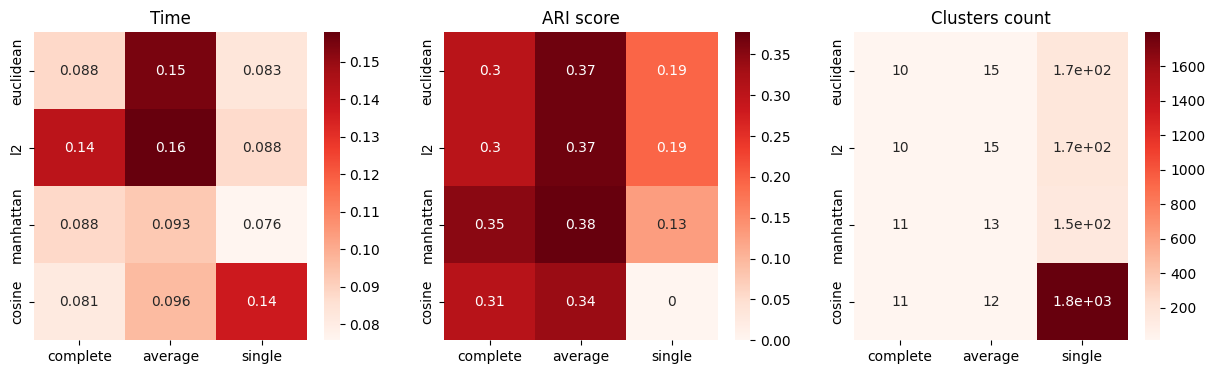

In [ ]:
import seaborn as sns

def plot_clustering_heatmap(X, y_true):
  distances = ['euclidean', 'l2', 'manhattan', 'cosine']
  linkages = ['complete', 'average', 'single']

  time, ari, n_clusters = np.ndarray((len(distances), len(linkages))), np.ndarray((len(distances), len(linkages))), np.ndarray((len(distances), len(linkages)))

  for i, metric in enumerate(distances):
    for j, linkage in enumerate(linkages):
      #print(metric, linkage)
      try:
        _, metrics, _, n = find_optimal_clustering(X, y_true, metric=metric, linkage=linkage, iterations=50)
        #print(metrics)
        time[i, j], ari[i, j], n_clusters[i, j] = metrics['Time'], metrics['ARI'], n
      except Exception as e:
        print(e)
        time[i, j], ari[i, j], n_clusters[i, j] = 0, 0, 0

  fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 4))
  sns.heatmap(time, ax=ax1, annot=True, cmap='Reds', xticklabels=linkages, yticklabels=distances)
  sns.heatmap(ari, ax=ax2, annot=True, cmap='Reds', xticklabels=linkages, yticklabels=distances)
  sns.heatmap(n_clusters, ax=ax3, annot=True, cmap='Reds', xticklabels=linkages, yticklabels=distances)
  ax1.set_title('Time')
  ax2.set_title('ARI score')
  ax3.set_title('Clusters count')
  plt.show()

plot_clustering_heatmap(pca_2d_embeddings, y_true)

Гипотеза о том, что PCA-эмбеддинги лучше кластеризовать по косинусному расстоянию, оказалась неверной.

Напомню, мы стремимся к наименьшему времени кластеризации, наибольшему ARI и близкому к 10 количеству кластеров. По графикам я делаю вывод, что лучший вариант для двумерных PCA-эмбеддингов - манхеттенское расстояние + complete linkage. Пробуем его визуализировать.

In [ ]:
_, metrics, y_pca, n = find_optimal_clustering(pca_2d_embeddings, y_true, metric='manhattan', linkage='complete')
print(metrics)

{'Time': 0.09280484500004604, 'ARI': 0.35014451021984155}


In [ ]:
from sklearn.metrics import pairwise_distances
from collections import Counter
from mpl_toolkits import mplot3d
%matplotlib inline

def class_purity(y_true, y_pred, cls):
    class_mask = (y_true == cls)
    class_predictions = y_pred[class_mask]
    cluster_counts = Counter(class_predictions)
    purity = max(cluster_counts.values()) / len(class_predictions)
    return purity

def plot_clustering(title, X, y_true, y_pred, metric):
    fig, plots = plt.subplots(2, 2, figsize=(12,12))
    fig.suptitle(title)
    plt.prism()

    n_clusters = len(np.unique(y_true))
    purities = []

    ax = fig.add_subplot(2, 2, 1, projection='3d') if X.shape[1] == 3 else plots[0, 0]
    for i in range(n_clusters):
        digit_indices = (y_true == i)
        purities.append(class_purity(y_true, y_pred, i))
        dims = [X[digit_indices, i] for i in range(X.shape[1])]
        ax.set_title('Original')
        ax.scatter(*dims, label=f"Digit {i}")
        ax.legend()

    purities.append(np.average(purities))

    avg_dist = np.zeros((n_clusters, n_clusters))
    for i in range(n_clusters):
        for j in range(n_clusters):
            avg_dist[i, j] = pairwise_distances(
                X[y_true == i], X[y_true == j], metric=metric
            ).mean()
    avg_dist /= avg_dist.max()
    sns.heatmap(avg_dist, ax=plots[1, 0], annot=True, cmap='Reds', xticklabels=np.arange(n_clusters), yticklabels=np.arange(n_clusters))

    inner_distances = [avg_dist[i, i] for i in range(n_clusters)]
    inner_distances.append(np.average(inner_distances))
    sns.heatmap([inner_distances, purities], ax=plots[1, 1], annot=True, cmap='Reds', xticklabels=[*np.arange(n_clusters), 'avg'], yticklabels=['inner distance', 'purity'])

    n_clusters = len(np.unique(y_pred))

    ax = fig.add_subplot(2, 2, 2, projection='3d') if X.shape[1] == 3 else plots[0, 1]
    for i in range(n_clusters):
        digit_indices = (y_pred == i)
        dims = [X[digit_indices, i] for i in range(X.shape[1])]
        ax.set_title('Embeddings')
        ax.scatter(*dims, label=f"Cluster {i}")
        ax.legend()

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

<ipython-input-70-45154777f98d>:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


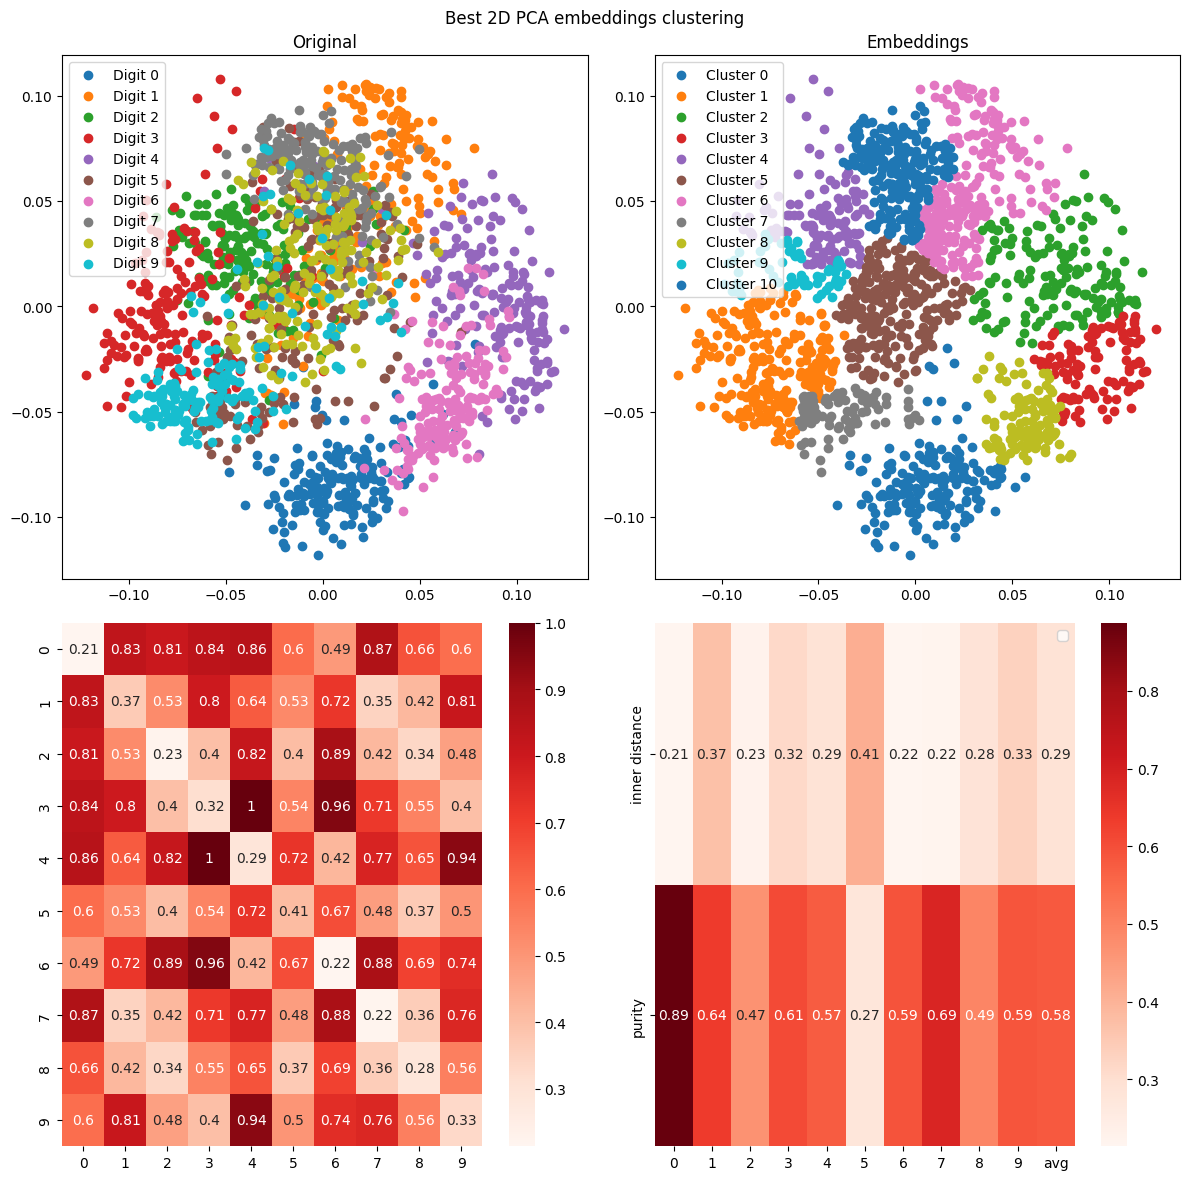

In [ ]:
plot_clustering('Best 2D PCA embeddings clustering', pca_2d_embeddings, y_true, y_pca, 'manhattan')

Ну, при ARI 0.35 чего-то более правдоподобного можно было и не ждать.

Замечания:
1. Между внутрикластерным расстоянием и "чистотой" классов (не отражает полную картину, но в нашем случае очень показательна) существует обратная зависимость: PCA не смог собрать пятёрки в плотную кучу, далёкую от остальных цифр, поэтому пятёрка плохо кластеризовалась по манхеттенскому расстоянию.
2. Судя по межкластерным расстояниям, больше всего пятёрка смешивалась с восьмёркой и с двойкой (можно сравнить на глаз с визуализацией самих данных).
3. Запоминаем для будущего сравнения среднее внутрикластерное расстояние и чистоту классов.

Едем дальше. Пробуем дать PCA ещё один шанс, добавив новое измерение.

In [ ]:
pca_3d_embeddings = PCA(n_components=3).fit_transform(X)

In [ ]:
_, metrics, y_pca, n = find_optimal_clustering(pca_3d_embeddings, y_true, metric='manhattan', linkage='complete')
print(metrics)

{'Time': 0.10133230999963416, 'ARI': 0.44193503584912963}


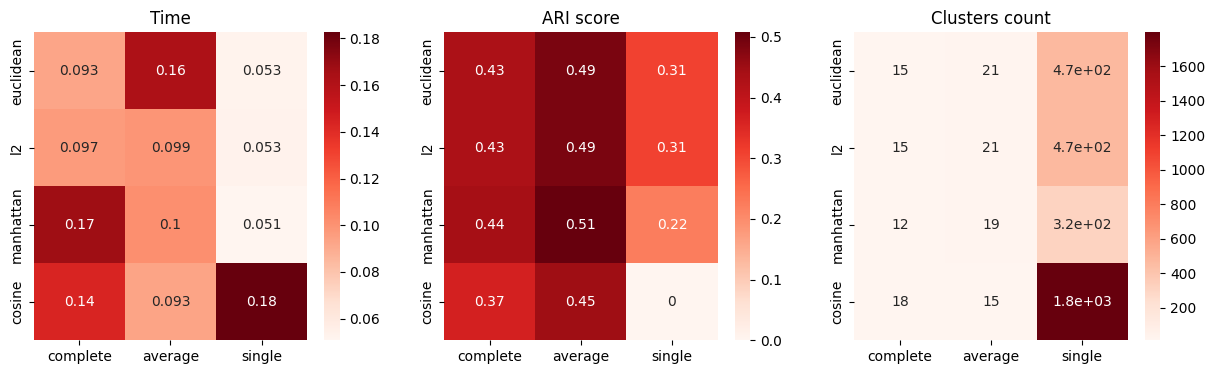

In [ ]:
plot_clustering_heatmap(pca_3d_embeddings, y_true)

ARI существенно подрос (почти на треть). Это говорит о том, что добавление нового измерения позволило выявить какой-то латентный признак в данных.

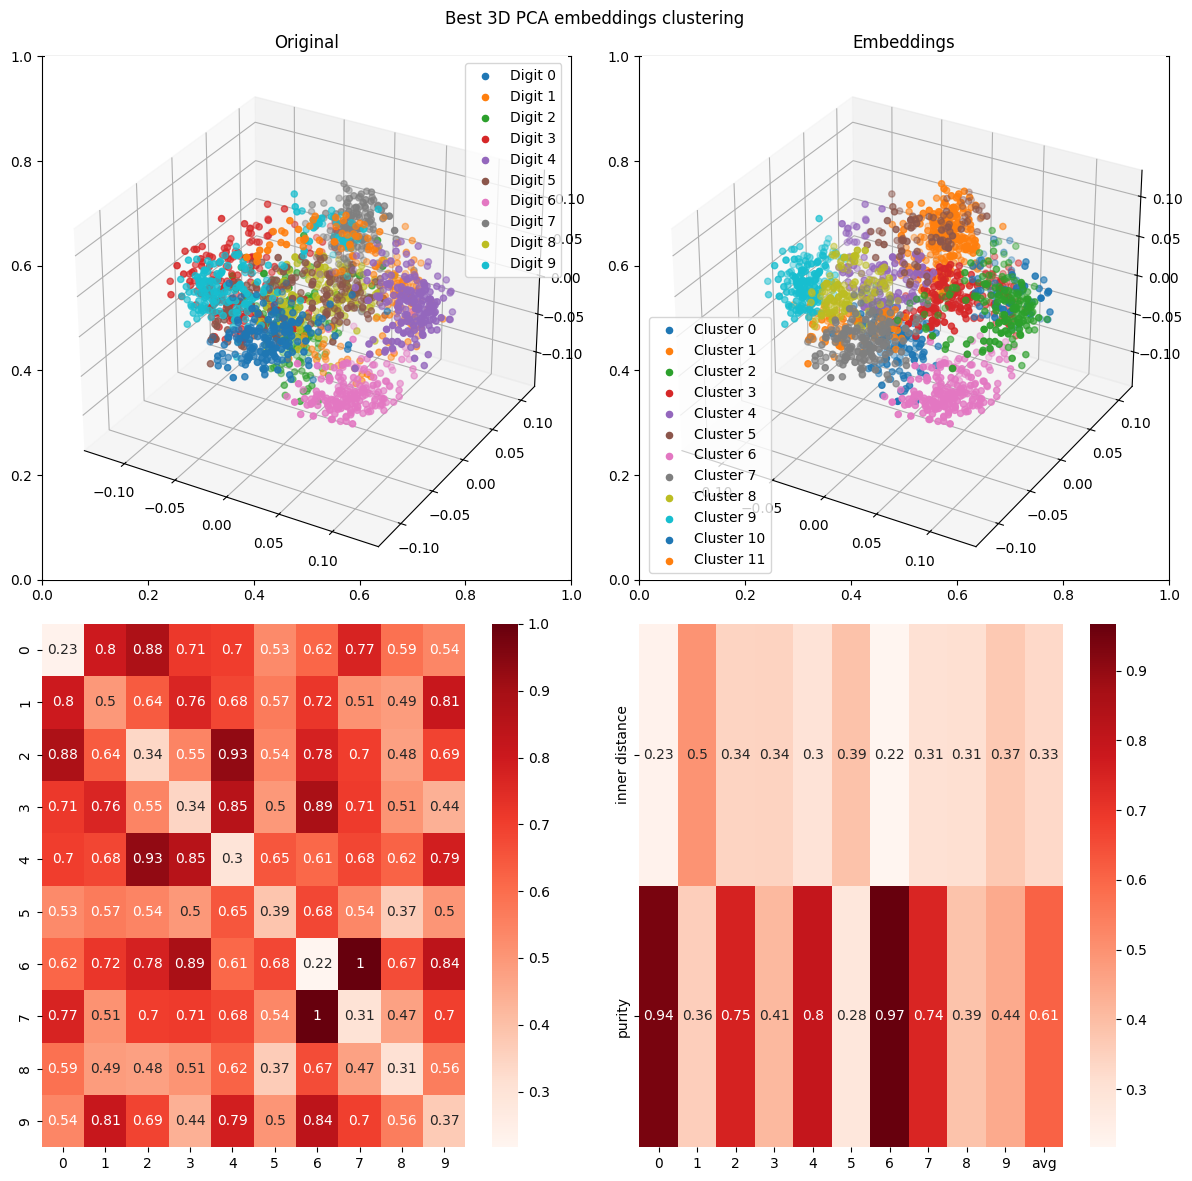

In [ ]:
plot_clustering('Best 3D PCA embeddings clustering', pca_3d_embeddings, y_true, y_pca, 'manhattan')

In [ ]:
_, metrics, y_pca, n = find_optimal_clustering(pca_3d_embeddings, y_true, metric='manhattan', linkage='average')
print(metrics)

{'Time': 0.09289003799995044, 'ARI': 0.5093010022575812}


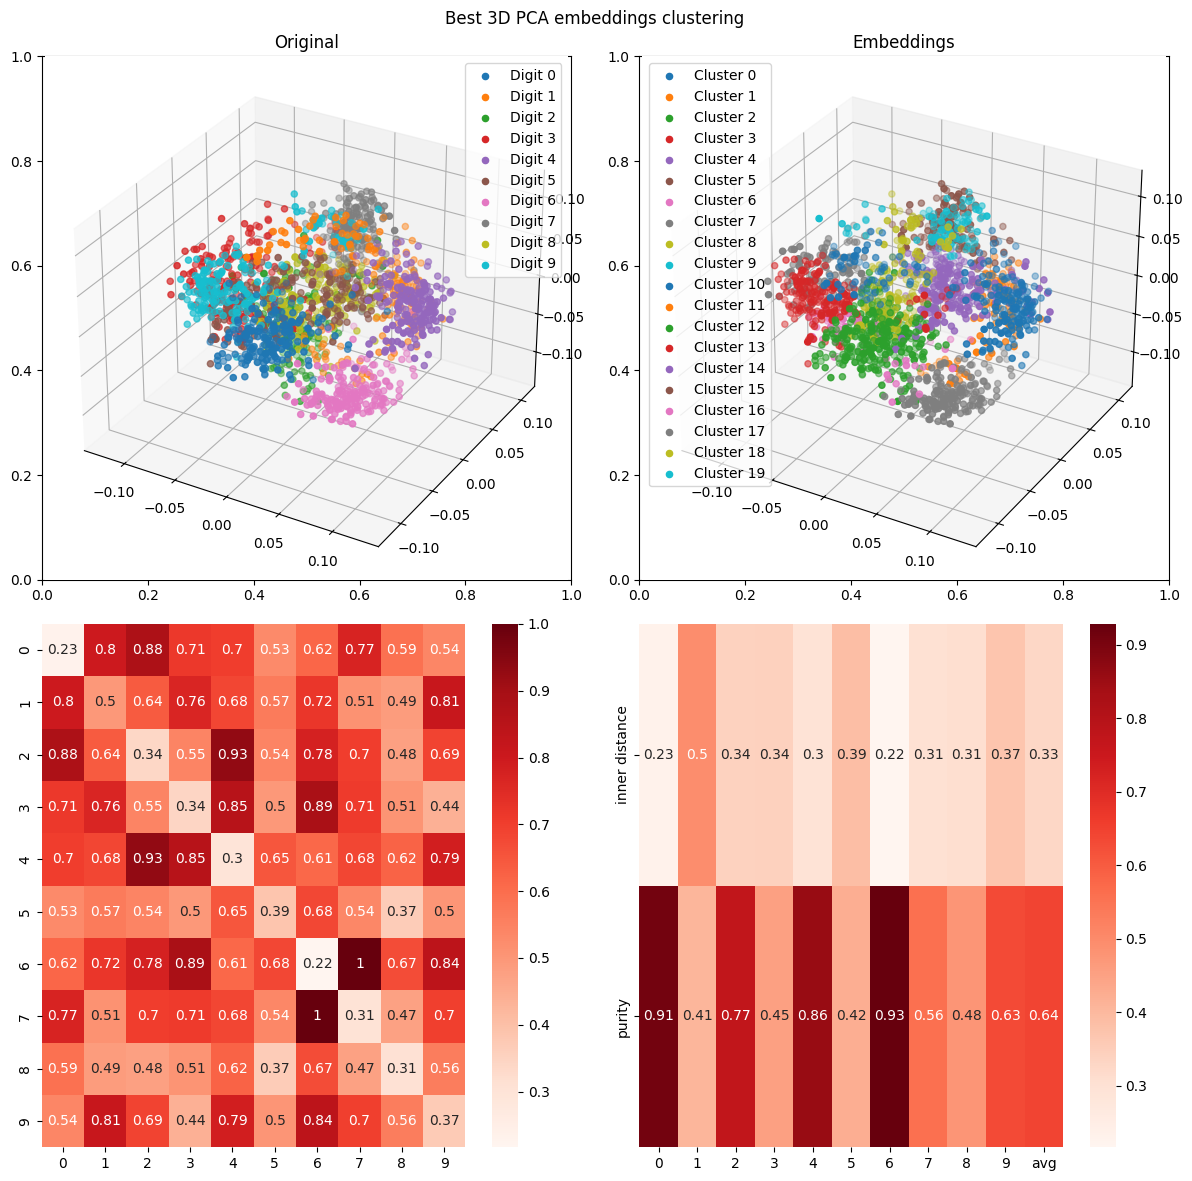

In [ ]:
plot_clustering('Best 3D PCA embeddings clustering', pca_3d_embeddings, y_true, y_pca, 'manhattan')

Действительно! Можно видеть, как третье измерение разделило в пространстве некоторые сильно смешанные кластеры.

Но глобально проблемы остались те же, если смотреть на качество кластеризацими отдельных цифр. И в отличие от ARI, среднее внутрикластерное расстояние и чистота классов остались примерно на том же уровне.

В PCA пока не вижу больше перспектив, поэтому перехожу ко второму по быстродействию методу - UMAP

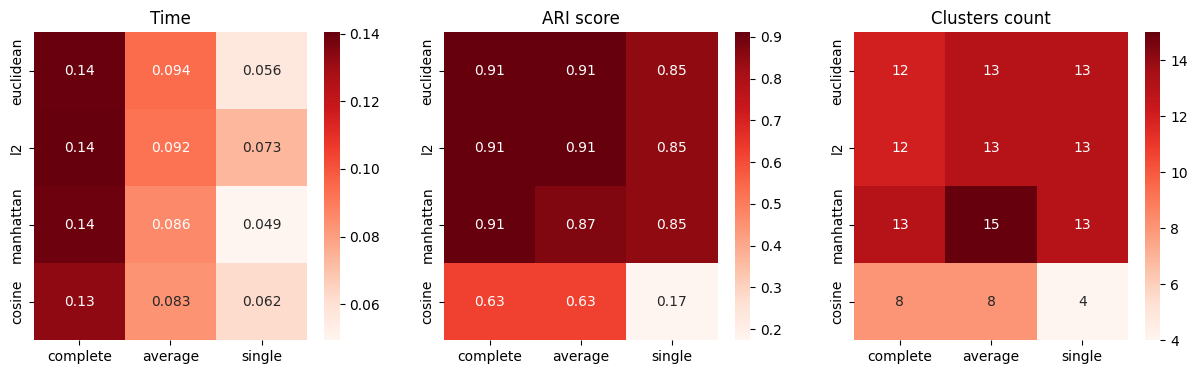

In [ ]:
plot_clustering_heatmap(umap_2d_embeddings, y_true)

Картина стала существенно лучше.

Тот факт, что метрики оказались лучше, чем при кластеризации исходных изображение говорит о том, что UMAP успешно справился не только с задачей понижения размерности данных, но и с поиском скрытых закономерностей в них.

Повторим процедуру выбора оптимального способа подсчёта расстояния и посмотрим, так ли хороши полученные цифры.

In [ ]:
_, metrics, y_umap, n = find_optimal_clustering(umap_2d_embeddings, y_true, metric='euclidean', linkage='average')
print(metrics)

{'Time': 0.13974673499978962, 'ARI': 0.9085722924799667}


<ipython-input-70-45154777f98d>:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


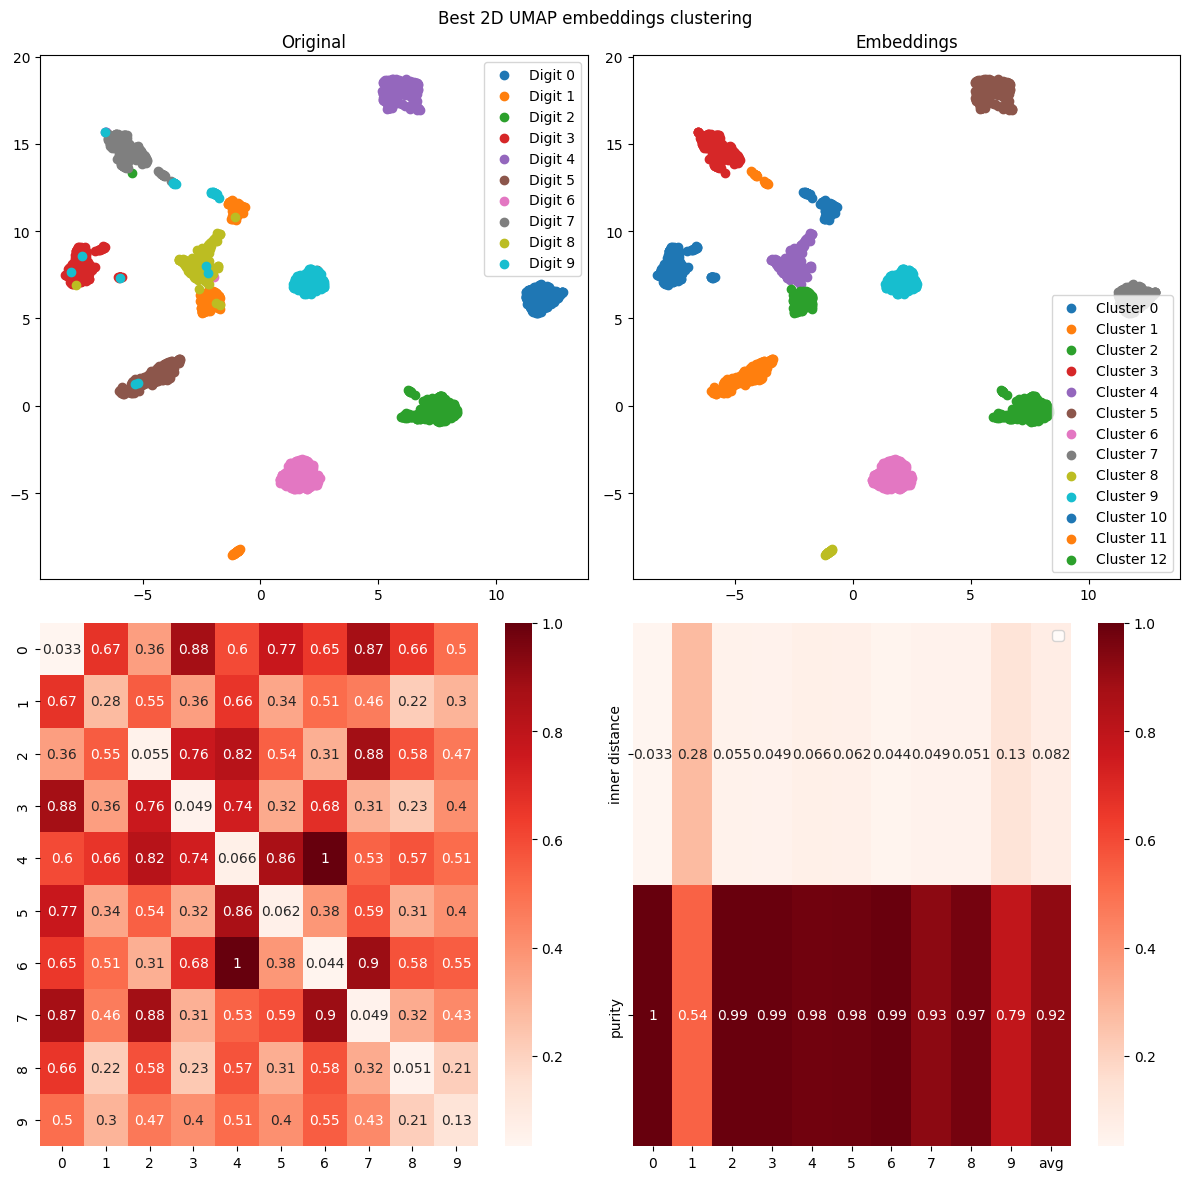

In [ ]:
plot_clustering('Best 2D UMAP embeddings clustering', umap_2d_embeddings, y_true, y_umap, 'euclidean')

Да, цифры не соврали, - UMAP смог за большее время намного лучше уместить наши данные в 2 измерения, об этом говорит уменьшение межкластерных расстояний и увеличение чистоты исходных классов.

При этом проблемы теперь совершенно другие:
- девятка сильно смешалась с восьмёркой и единицей;
- единица сильно перемешалась с остальными и распалась на 3 кластера.

Изменится ли качественно эта картина, если добавить третье измерение?

In [ ]:
umap_3d_embeddings = UMAP(n_components=3).fit_transform(X)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


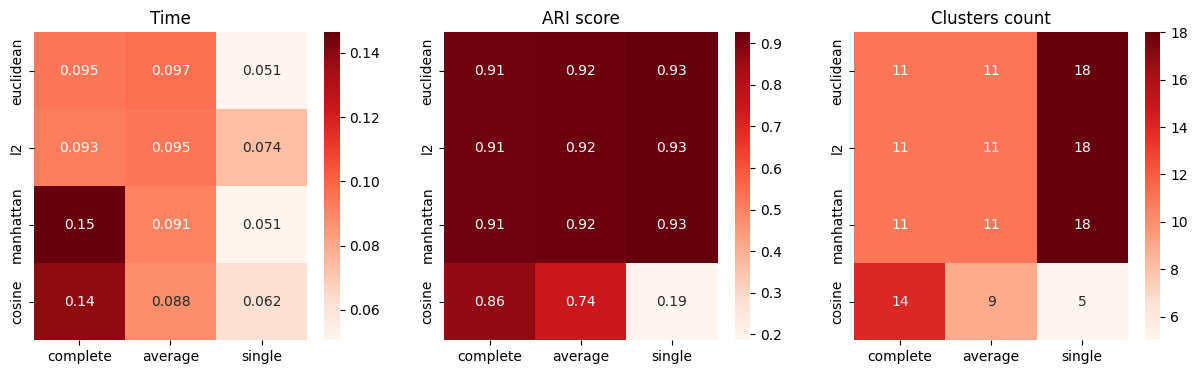

In [ ]:
plot_clustering_heatmap(umap_3d_embeddings, y_true)

In [ ]:
_, metrics, y_umap, n = find_optimal_clustering(umap_3d_embeddings, y_true, metric='euclidean', linkage='average')
print(metrics)

{'Time': 0.09091003499997896, 'ARI': 0.9161467466737548}


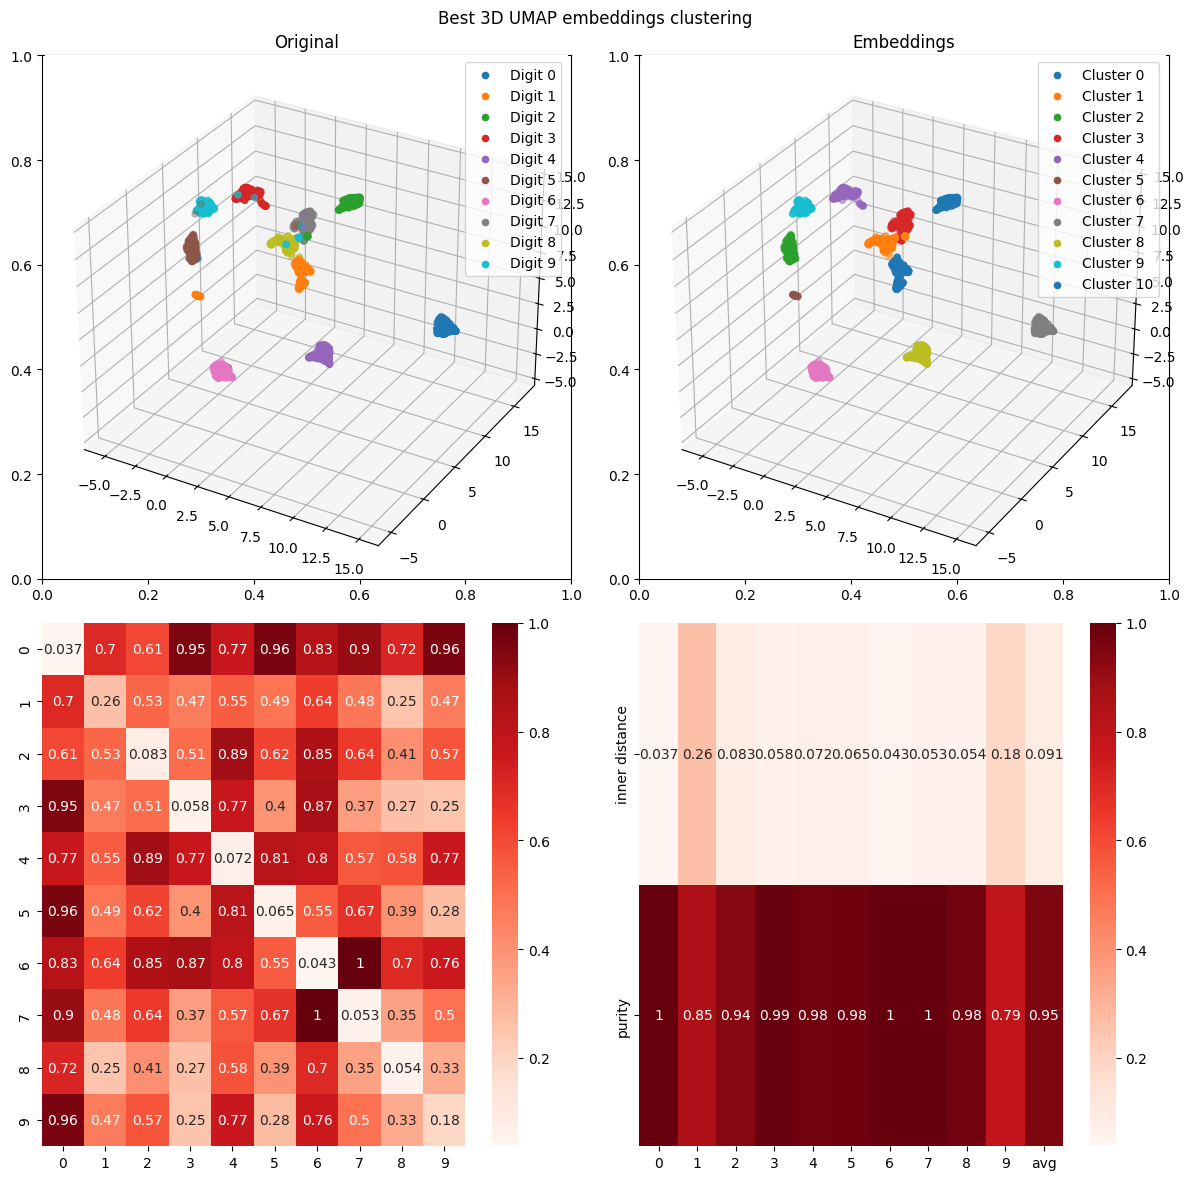

In [ ]:
plot_clustering('Best 3D UMAP embeddings clustering', umap_3d_embeddings, y_true, y_umap, 'euclidean')

Метрики ещё подросли, третье измерение неплохо расцепило кластеры и качественная картина улучшилась: диница стала намного чище, а вот девятка осталась точно такой же "грязной".

Не скажу, что после замеров времени я возлагаю надежды на t-SNE, но давайте попробуем. Визуально разбиение похоже на UMAP, поэтому метрики должны получиться схожими.

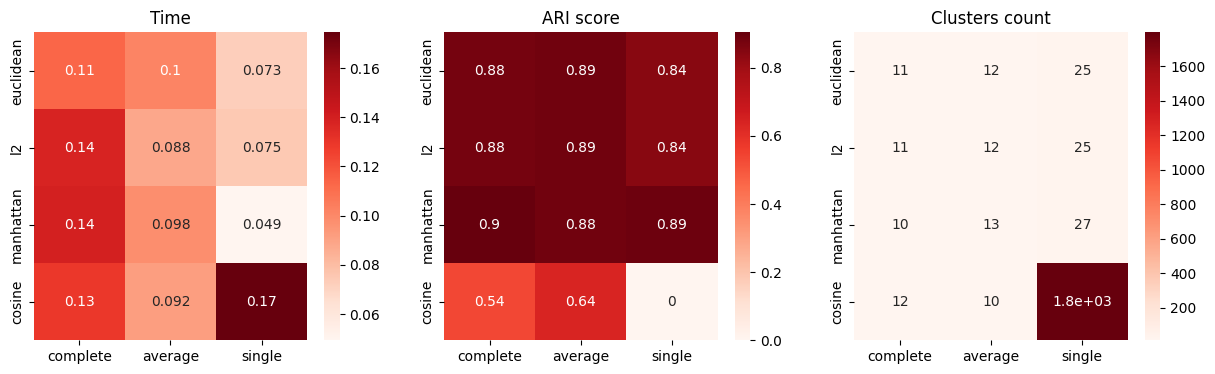

In [ ]:
plot_clustering_heatmap(tsne_2d_embeddings, y_true)

In [ ]:
_, metrics, y_tsne, n = find_optimal_clustering(tsne_2d_embeddings, y_true, metric='manhattan', linkage='complete')
print(metrics)

{'Time': 0.1565054640004746, 'ARI': 0.7890396132027927}


<ipython-input-70-45154777f98d>:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


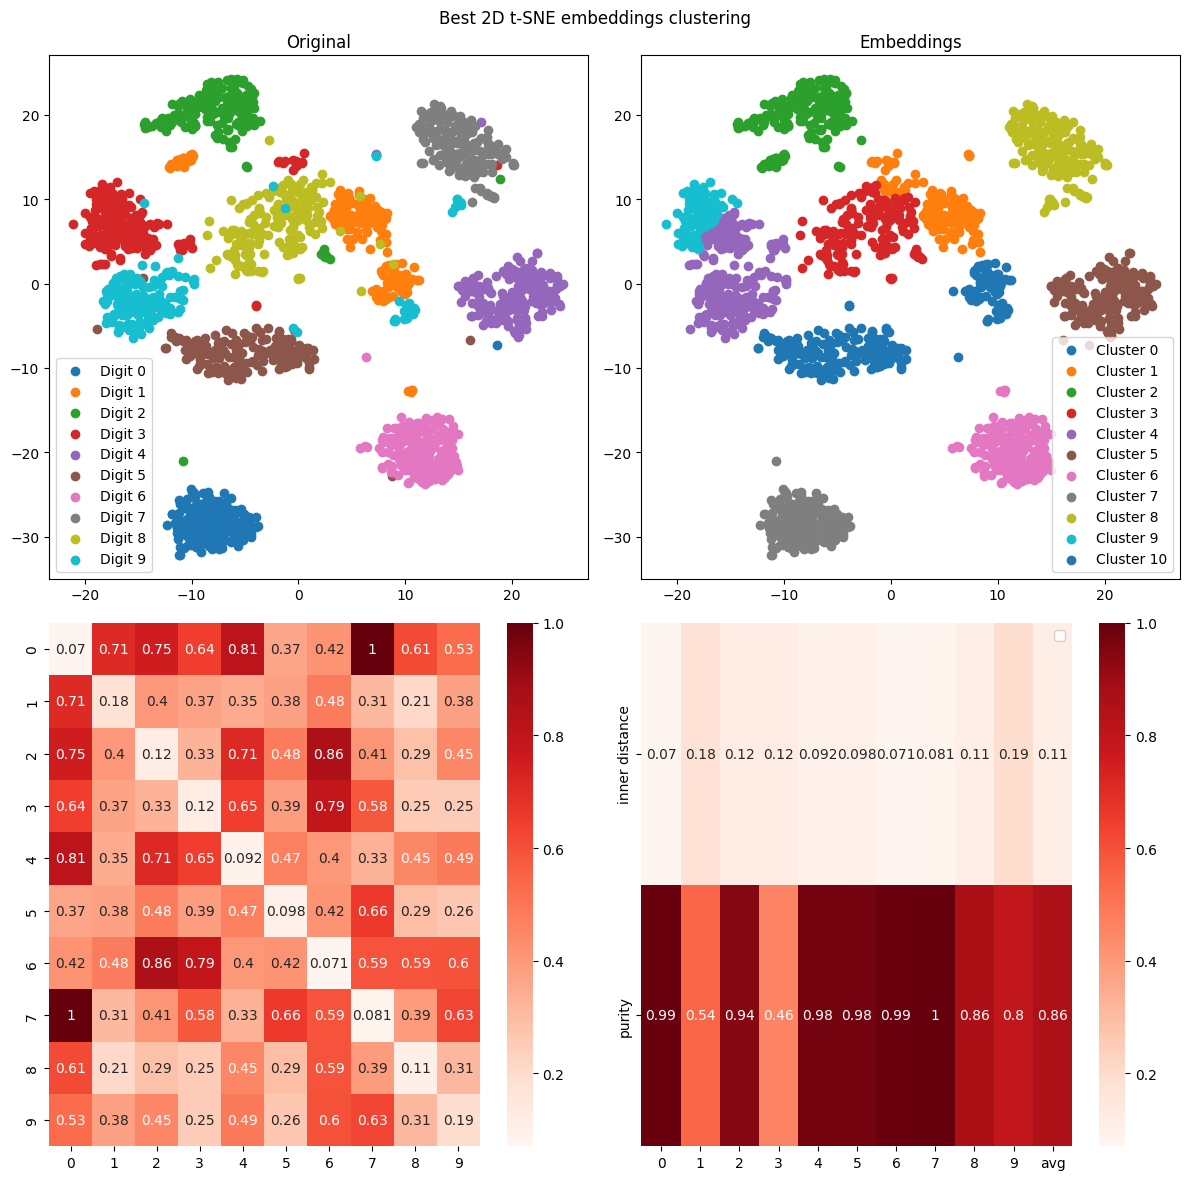

In [ ]:
plot_clustering('Best 2D t-SNE embeddings clustering', tsne_2d_embeddings, y_true, y_tsne, 'manhattan')

Да, метрики получились примерно такими же, только немного хуже из-за того, что качественная картина похожа на UMAP за исключением грязной тройки, которая смешалась с остальными. Ну и 8 с 1 сильнее спутались.

Посмотрим, получится ли добавлением нового измерения исправить ситуацию.

In [ ]:
tsne_3d_embeddings = TSNE(n_components=3, perplexity=40).fit_transform(X)

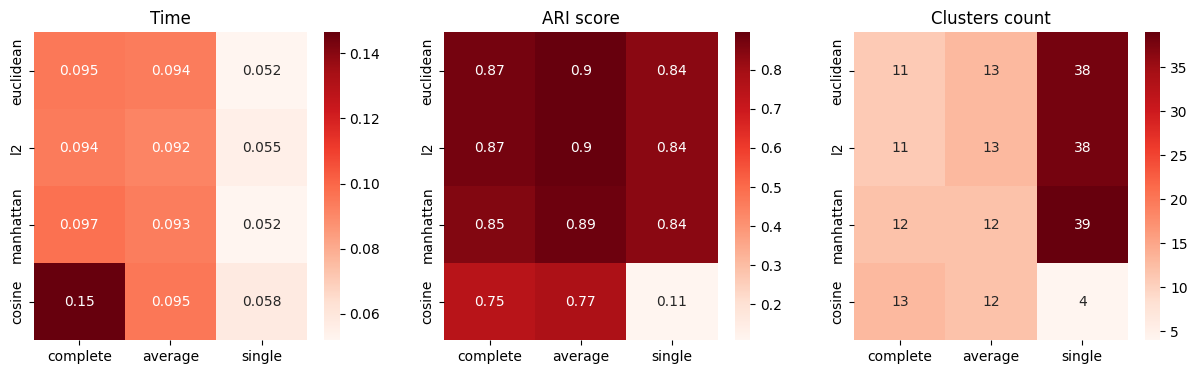

In [ ]:
plot_clustering_heatmap(tsne_3d_embeddings, y_true)

In [ ]:
_, metrics, y_tsne, n = find_optimal_clustering(tsne_3d_embeddings, y_true, metric='euclidean', linkage='average')
print(metrics)

{'Time': 0.14228859100012414, 'ARI': 0.895952612805589}


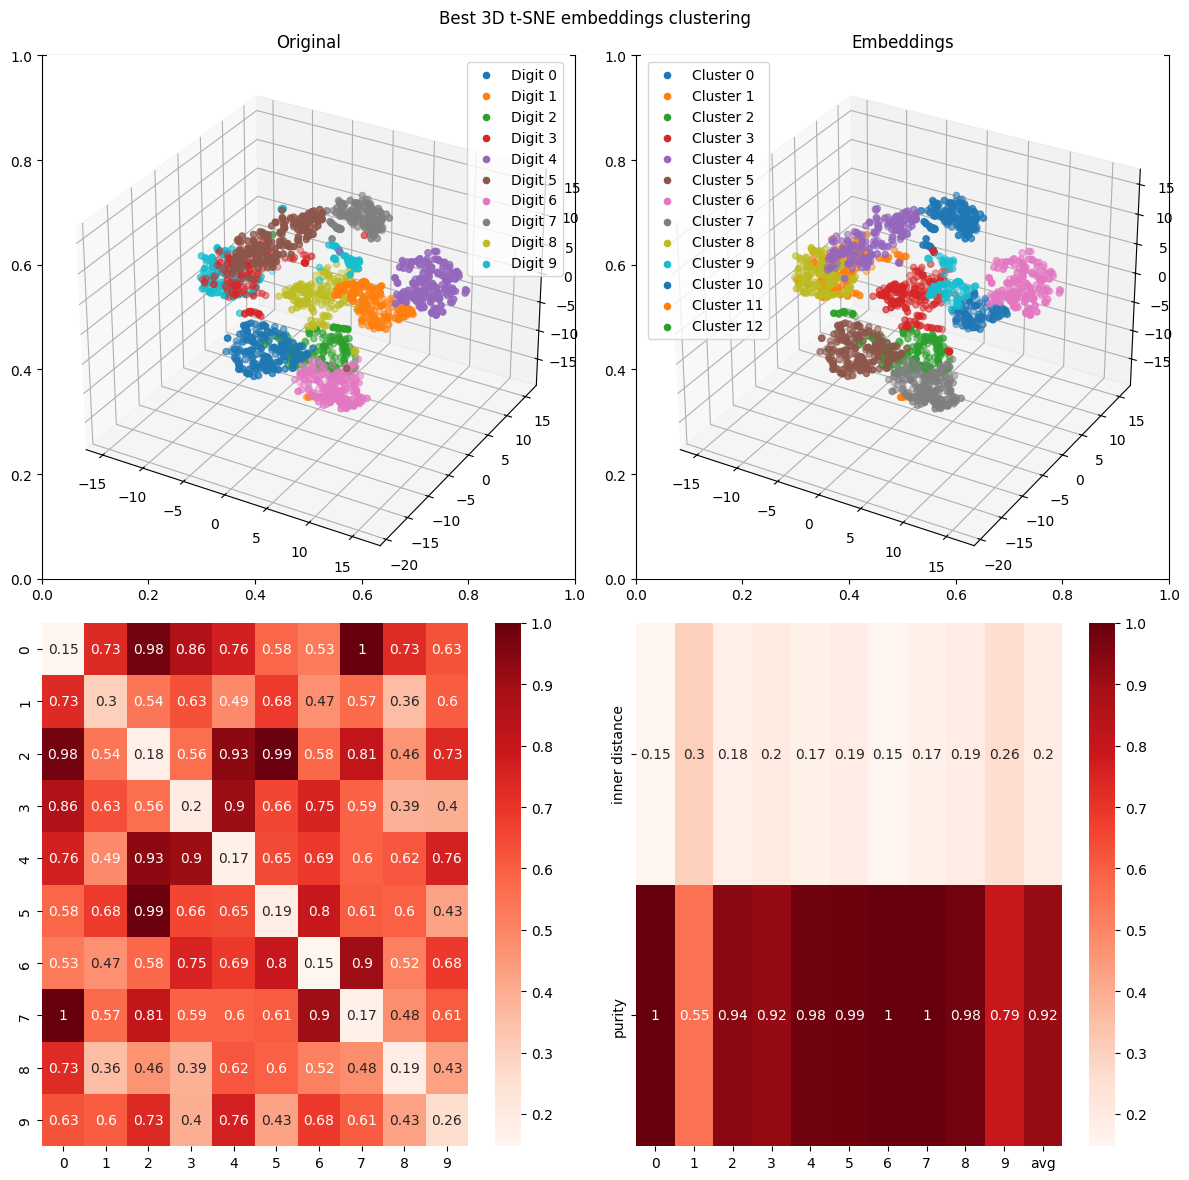

In [ ]:
plot_clustering('Best 3D t-SNE embeddings clustering', tsne_3d_embeddings, y_true, y_tsne, 'euclidean')

ARI остался на месте, а вот тройка и восьмёрка стали намного чище, так что качественная картина улучшилась.

Давайте продолжим играться с t-SNE и попробуем дотянуть его до UMAP с помощью изменения гиперпараметра **perplexity**.

Perplexity определяет баланс внимания между локальными и глобальными аспектами наших данных. Параметр, в некотором смысле, является предположением о количестве близких соседей, которые есть у каждой точки. В оригинальной статье говорится: «Производительность SNE довольно устойчива к изменениям в недоумении, а типичные значения составляют от 5 до 50».

До этого мы использовали perplexity 40, тперь попробуем 5 и 100.

In [ ]:
tsne_2d_embeddings = TSNE(n_components=2, perplexity=5).fit_transform(X)

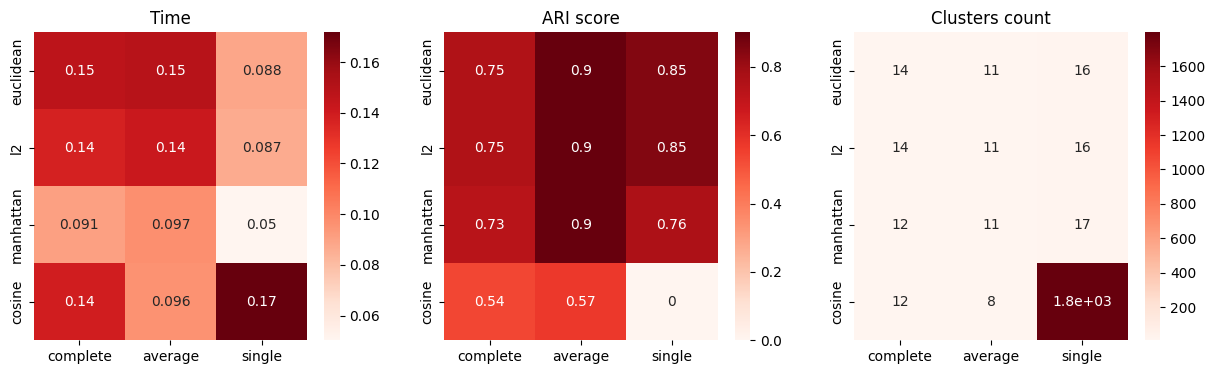

In [ ]:
plot_clustering_heatmap(tsne_2d_embeddings, y_true)

In [ ]:
_, metrics, y_tsne, n = find_optimal_clustering(tsne_2d_embeddings, y_true, metric='euclidean', linkage='average')
print(metrics)

{'Time': 0.09794931500027815, 'ARI': 0.9014243155990196}


<ipython-input-70-45154777f98d>:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


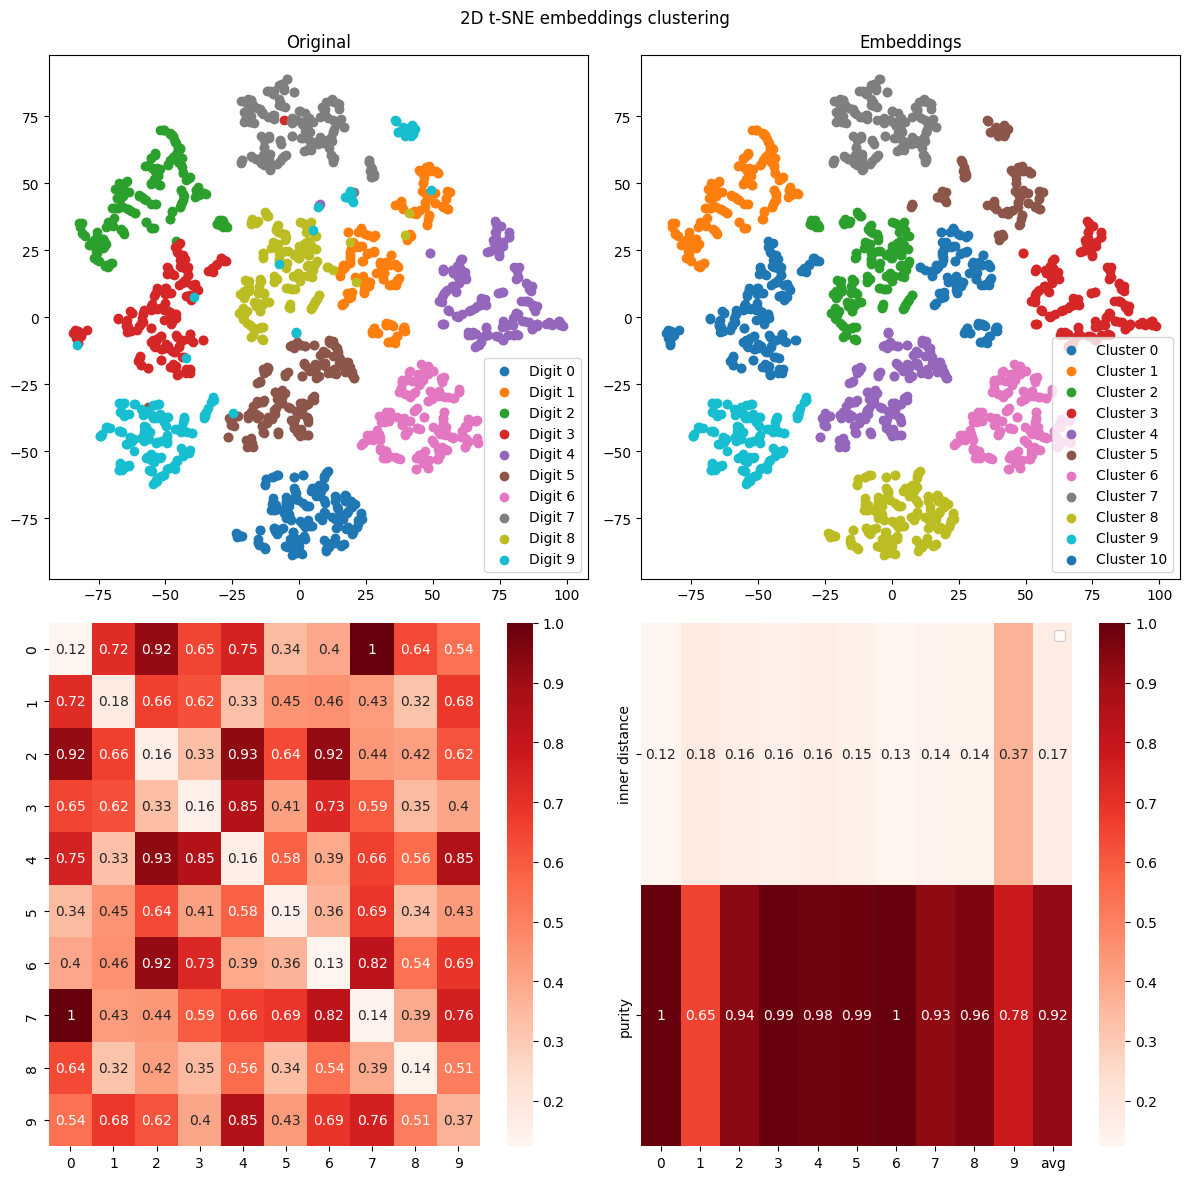

In [ ]:
plot_clustering('2D t-SNE embeddings clustering', tsne_2d_embeddings, y_true, y_tsne, 'euclidean')

In [ ]:
tsne_2d_embeddings = TSNE(n_components=2, perplexity=100).fit_transform(X)

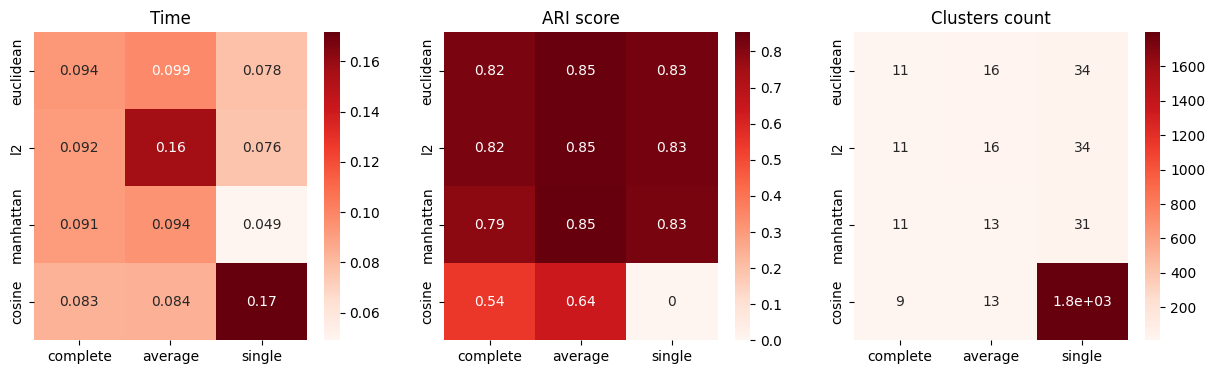

In [ ]:
plot_clustering_heatmap(tsne_2d_embeddings, y_true)

In [ ]:
_, metrics, y_tsne, n = find_optimal_clustering(tsne_2d_embeddings, y_true, metric='euclidean', linkage='complete')
print(metrics)

{'Time': 0.09374326300030589, 'ARI': 0.819199442529303}


<ipython-input-70-45154777f98d>:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


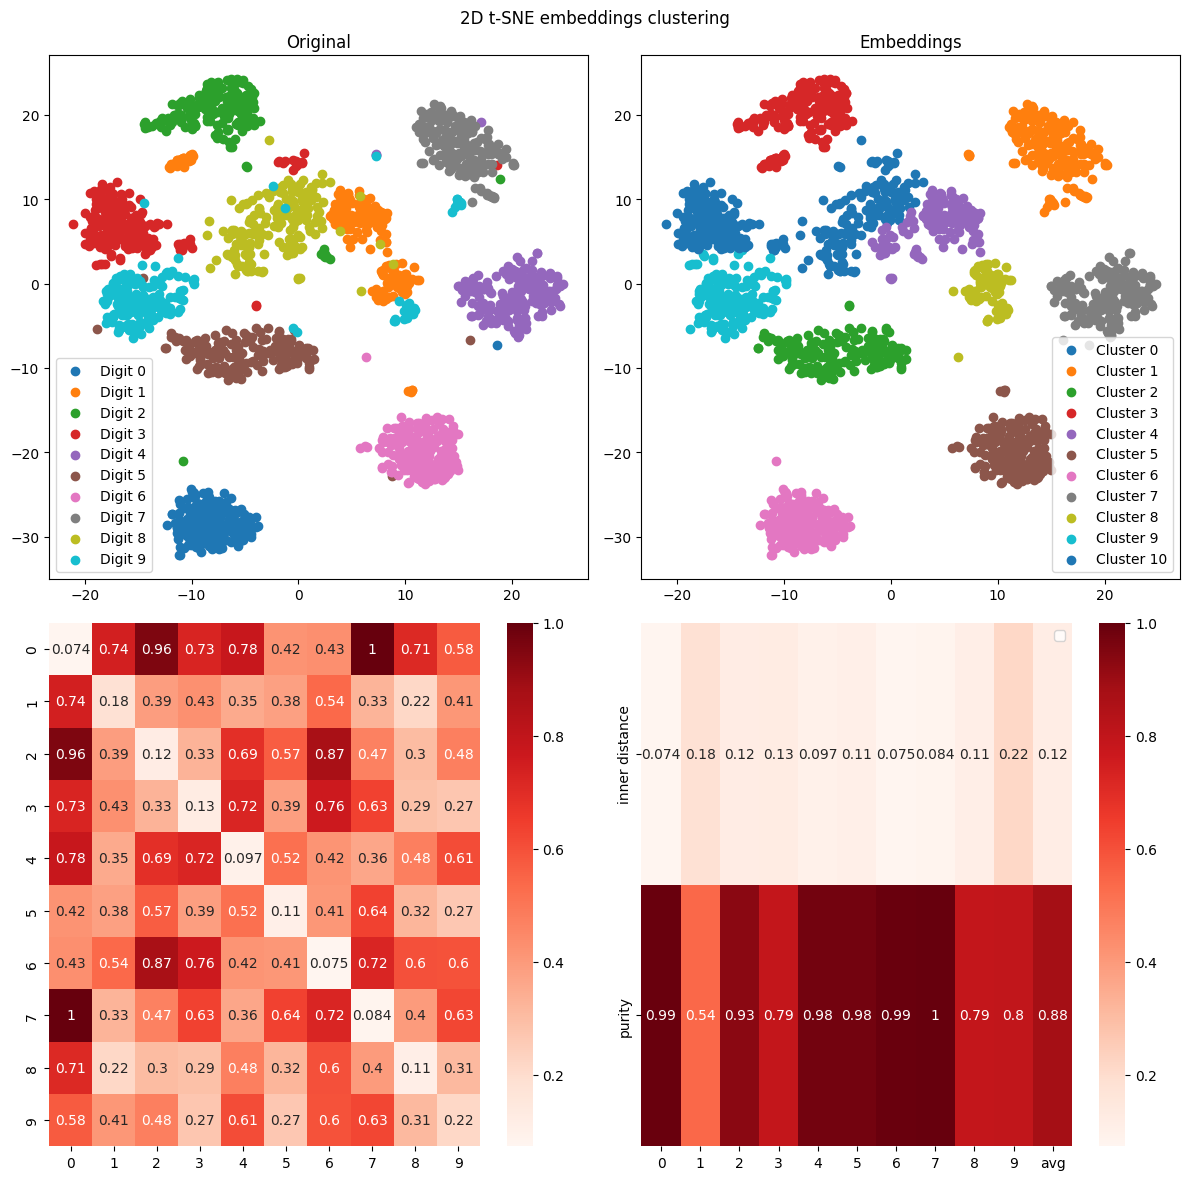

In [ ]:
plot_clustering('2D t-SNE embeddings clustering', tsne_2d_embeddings, y_true, y_tsne, 'euclidean')

Ни количественная, ни качественная картина не улучшились, так что делаем вывод о том, что оптимальный perplexity надо подбирать скорее в окрестности 40, чем в окрестности 5 или 100.

Итак, t-SNE не смог обойти ни 2D, ни 3D версию UMAP. Так, моим фаворитом остаётся 3D UMAP. Он оказался быстрее и точнее смог выявить скрытые закономерности в данных. По точности он может тягаться с какими-нибудь нейронками, обучаемыми под формирование эмбеддингов.

Но на визуализации вы видели, что нам мешали выбросы (когда хочется повысить ARI с 0.92, приходится обращать внимание и на это). Я считаю, что это обусловлено размытостью исходных изображений. Некоторые цифры и мне отличить сложно в разрешении 8 на 8. Попробуем помочь UMAP достичь новых вершин и попробуем разрешение 28 на 28.

In [ ]:
mnist = sklearn.datasets.fetch_openml('mnist_784')
print(mnist.data.shape)

(70000, 784)


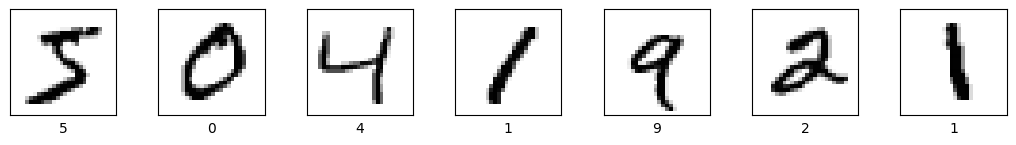

In [ ]:
plot_mnist(mnist.data, mnist.target, (28, 28))

WARN: дальше я из-за копипасты продолжил работать с изображениями 8 на 8 ахахахахах

facepalm

In [ ]:
X, y_true = images, target.astype(int)
X = X.astype(np.float32) / 255.0

In [ ]:
umap_3d_embeddings = UMAP(n_components=3).fit_transform(X)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


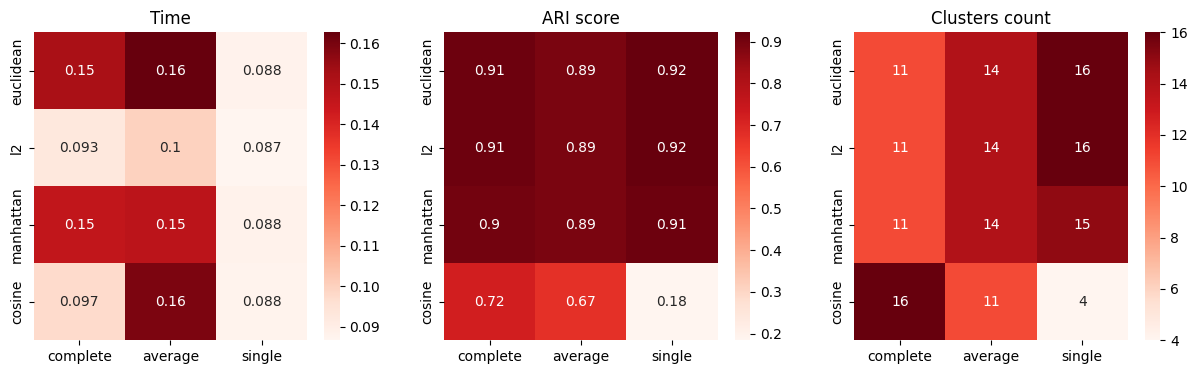

In [ ]:
plot_clustering_heatmap(umap_3d_embeddings, y_true)

In [ ]:
_, metrics, y_umap, n = find_optimal_clustering(umap_3d_embeddings, y_true, metric='euclidean', linkage='complete')
print(metrics)

{'Time': 0.15842550399975153, 'ARI': 0.9127863149051932}


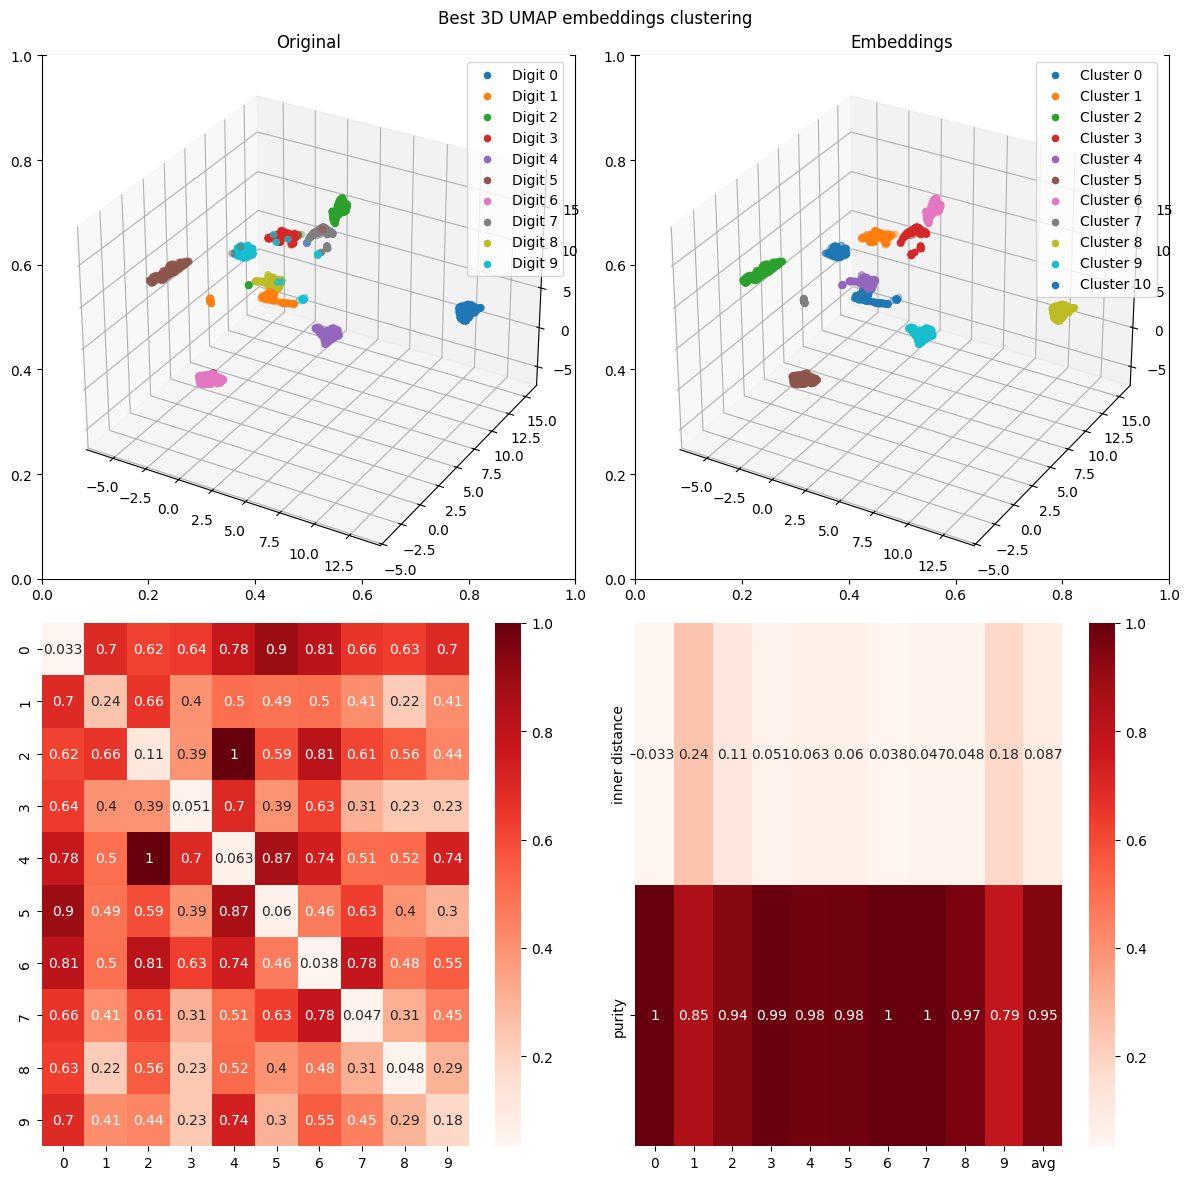

In [ ]:
plot_clustering('Best 3D UMAP embeddings clustering', umap_3d_embeddings, y_true, y_umap, 'euclidean')

Метрики остались на месте, девятка и единица такие же "грязные". Повышение разрешения не помогло кластеризации. Допускаю, что неправильно идентифицированным цифрам и разрешение 1920 на 1080 может не помочь...

К вопросу о гиперпарпметрах. у UMAP есть важный гиперпараметр - число соседей (похож по смыслу на perplexity у t-SNE). По дефолту оно было равно 15, теперь попробуем другие значения и посмотрим, как они отразятся на общей картине.

In [ ]:
umap_3d_embeddings = UMAP(n_components=3, n_neighbors=7).fit_transform(X)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


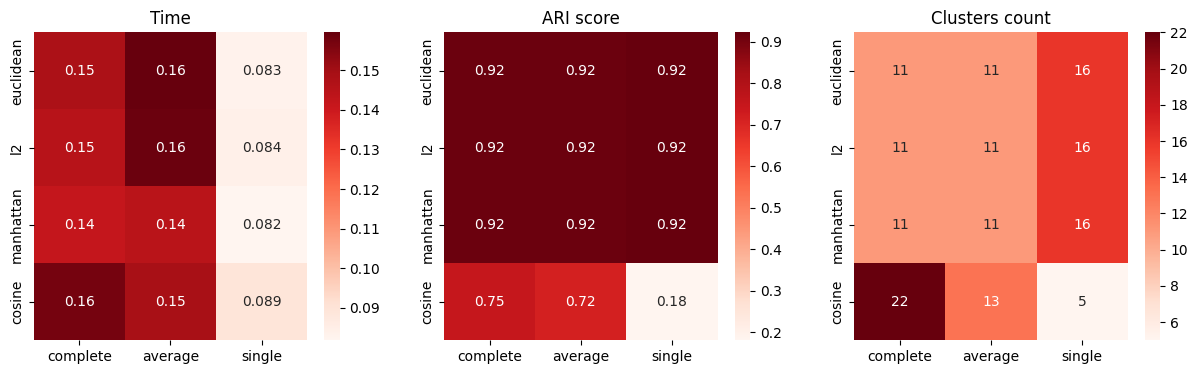

In [ ]:
plot_clustering_heatmap(umap_3d_embeddings, y_true)

In [ ]:
_, metrics, y_umap, n = find_optimal_clustering(umap_3d_embeddings, y_true, metric='euclidean', linkage='complete')
print(metrics)

{'Time': 0.15329011799985892, 'ARI': 0.9160043465082195}


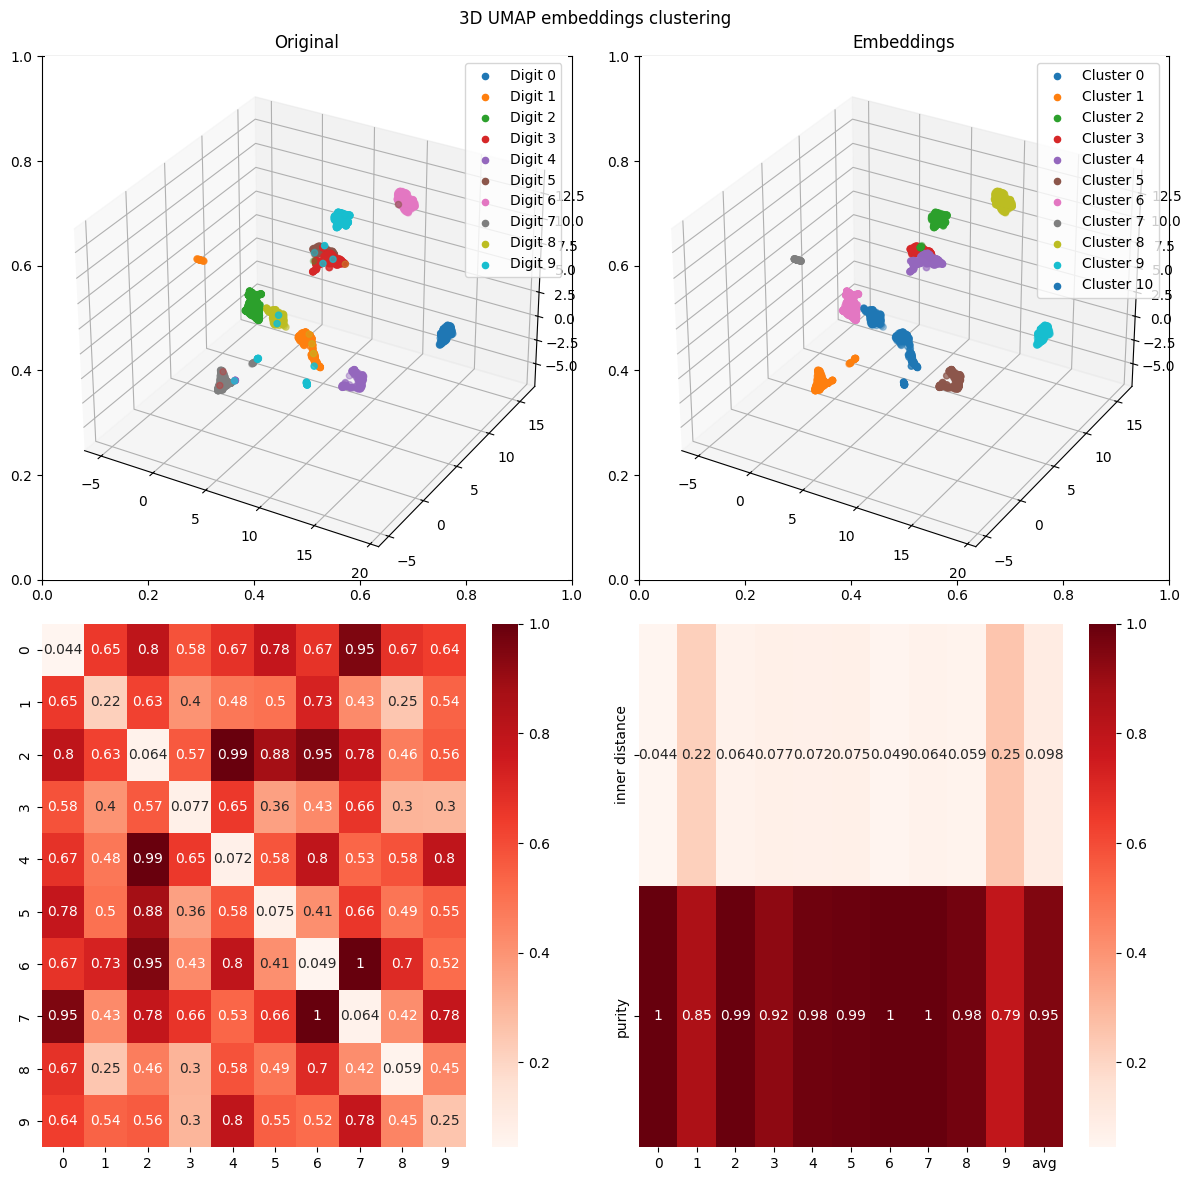

In [ ]:
plot_clustering('3D UMAP embeddings clustering', umap_3d_embeddings, y_true, y_umap, 'euclidean')

При уменьшении числа соседей улучшения метрик не получили. Пробуем увеличить число соседей.

In [ ]:
umap_3d_embeddings = UMAP(n_components=3, n_neighbors=30).fit_transform(X)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


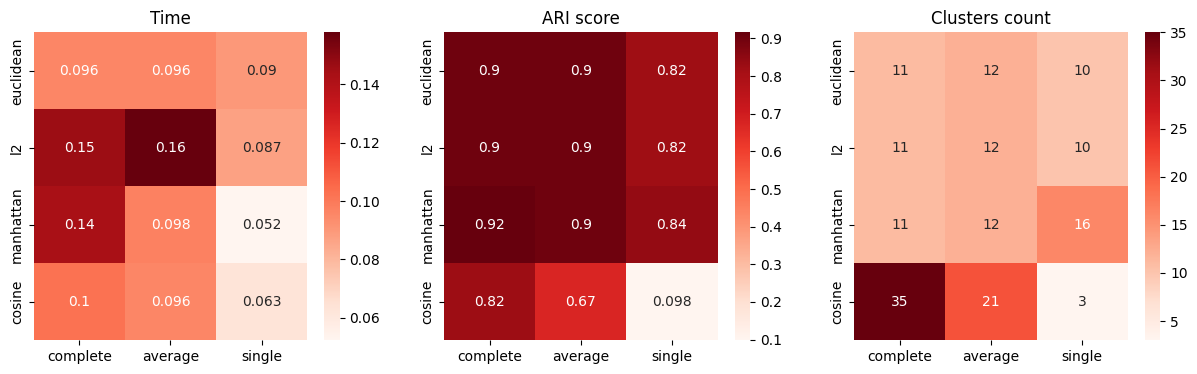

In [ ]:
plot_clustering_heatmap(umap_3d_embeddings, y_true)

In [ ]:
_, metrics, y_umap, n = find_optimal_clustering(umap_3d_embeddings, y_true, metric='manhattan', linkage='complete')
print(metrics)

{'Time': 0.14528423000047042, 'ARI': 0.916001353869369}


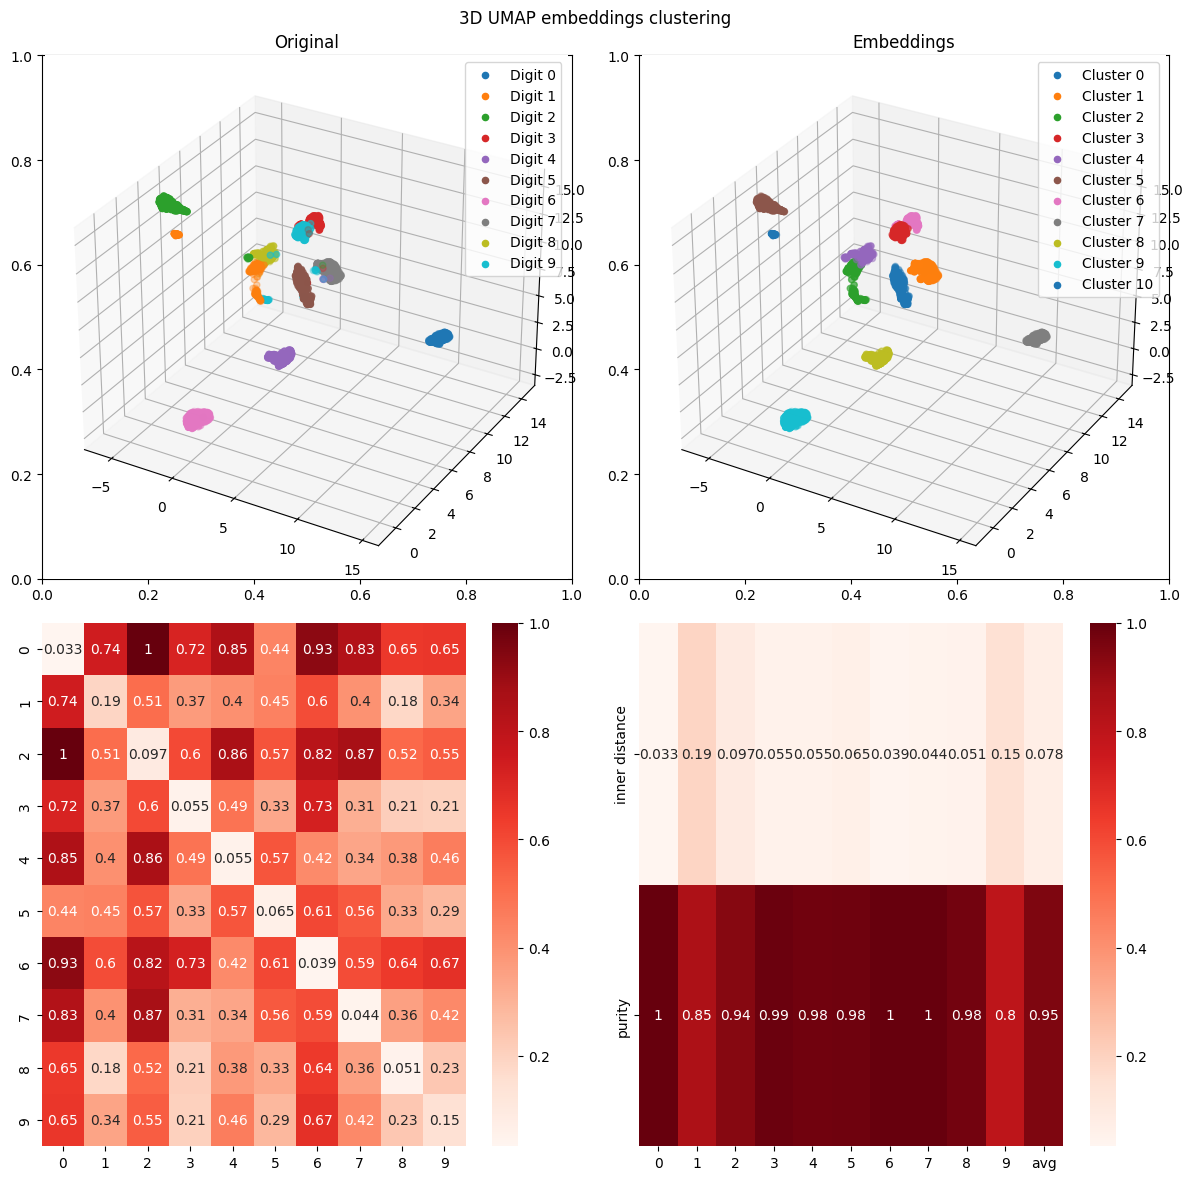

In [ ]:
plot_clustering('3D UMAP embeddings clustering', umap_3d_embeddings, y_true, y_umap, 'manhattan')

Рекорд ARI остался непобитым, чистота классов улучшилась у тройки. И наконец-то девятка стала "чище" хотя бы на 0.01. Ещё и единица распадается не на 3 кластера, а всего на два (и образуя вместе с остальными цифрами 11 кластеров, но не будем заострять на этом внимание). Я буду считать это своей победой над данными и пойду спать.

Замечания от препода по ходу сдачи:
- я перепутал L1 и L2 расстояния, посчитав, что L1 и евклидово это одно и то же (facepalm);
- Возможно вместо `pairwise_distances` для подсчёта внутрикластерных и межкластерных расстояний стоило для большей наглядности использовать `davies_bouldin_score` (Davies–Bouldin index, DBI).